# Putting things together 3

Here we will define a cell model with multiple sections and create a network model.

## Training of network models

- Artificial neural network models are optimized to generate ideal behavior, 
    - E.g., replication of data with the smallest error possible. 
- Those optimization, or training methods are rarely related to mechanisms in the biological neural circuits.
- But what would happen if we optimize the models of biological neural networks by those artificial methods?

![](imgs/zipster_1.png)

- They trained the three-layer neural network model of the visual pathway by backpropagation, which replicated their experimental data from the visual cortical neurons.
- This is hardly biological since no backpropagation is possible from the visual cortex to retina.
- ????

![](imgs/zipster_2.png)


## Optimizing the network model

Optimizing a network model of spiking neurons is still a very difficult problem. Here, we use an approach by [Nicola and Clopath, Nat Commun, 2017](https://www.nature.com/articles/s41467-017-01827-3), which works relatively well.

The basic idea is
1. Find a linear decoder to fit the data by a linear combination of neuronal activity.
$$ z = {\bf \phi}\cdot {\bf r}$$
where $r_i$ is the 'rate' of the neuron $i$, computed by integrating the spikes with a time window, just like synaptic conductance.
2. Inject $z$ as a modulating input to neurons with some random weight ${\bf \eta}$,
$$ C\frac{dV_i}{dt} = \text{intrinsic current} + \text{network inputs} + \eta_i z$$
3. If we rewite the equation
$$ C\frac{dV_i}{dt} = \text{intrinsic current} + \text{network inputs} + \sum_{j}\eta_i \phi_j r_j$$
Note that the last term can be interpreted as modifying the network connectivity since $r_j$ can be thought as the synaptic conductance triggered by spike inputs from neuron $j$.
4. Now go back to step 1 and repeat the loop until converges.



### Plan

1. We will first run the simulation for a short time period,
2. Just as Nicola and Clopath, we will use the recursive least square (RLS) method to find $\bf \phi$.
3. We modify the connectivity accordingly by $\bf \phi$.
4. We will repeat the steps and hope that it converges!

### Network is all-to-all connected where the weights are from Gaussian random numbers

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange

Ncells= 1000

G = nx.DiGraph()

for i in range(Ncells):
    G.add_node(i)

for i in G.nodes:

    exc_pre = np.arange(0, Ncells)
    for k in G.nodes:
        if i!=k:  # No self-connection
            if k in exc_pre:
                G.add_edge(i, k, weight=np.random.randn())


/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_83075/2593670720.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


### We first create neurons in the network according to the plan:

In [2]:
from neuron import h, gui, load_mechanisms
from net_manager import SerialNetManager
from cell_models import Mainen

pnm = SerialNetManager(len(G.nodes))

for i in G.nodes:
    # pnm.register_cell(i, Mease(i))
    pnm.register_cell(i, Mainen(i, rho=80, c=10))

### Then, we add brief stimuli for the cells to kickstart the network activity

In [3]:
# Kickstart stims
ext_stims = []
ext_ncs = []
for i in G.nodes:
    stim = h.NetStimFD(pnm.gid2cell[i].soma(0.5))
    stim.interval = 4
    stim.noise = 1
    stim.start = 0
    stim.duration = 2
    stim.seed(i+1223)

    nc = h.NetCon(stim, pnm.gid2cell[i].synlist[1])
    nc.weight[0] = 6e-4
    ext_stims.append((stim, nc))

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Neuron')]

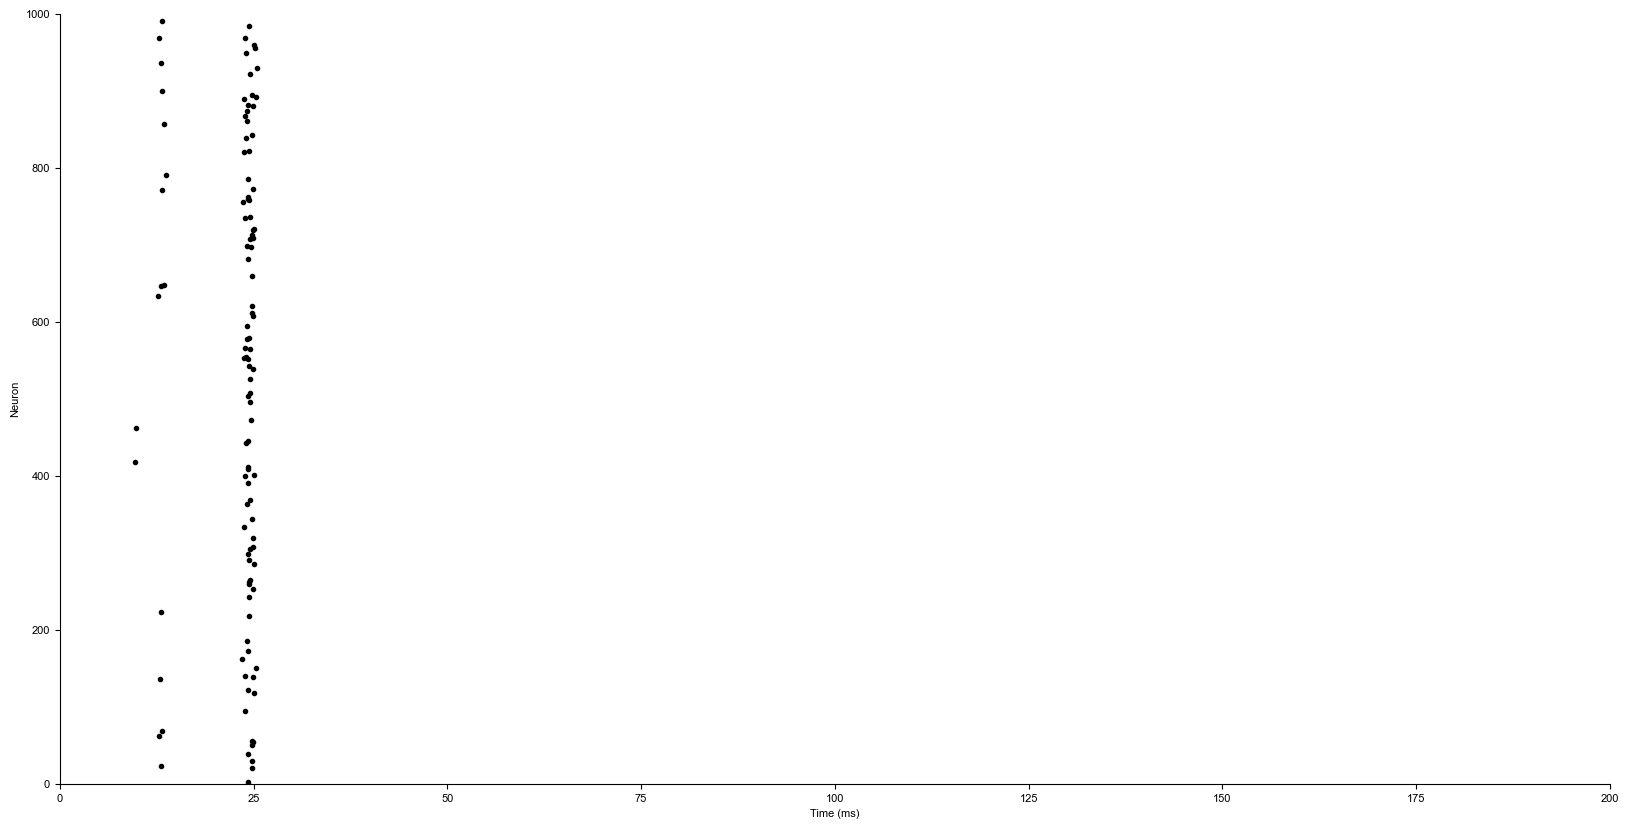

In [4]:
pnm.want_all_spikes()

h.tstop = 400
h.init()
pnm.run()

Ncells = len(G.nodes)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlim=[0, 200], ylim=[0, Ncells])
ax.set(xlabel='Time (ms)', ylabel='Neuron')

### Then we wire the cells for each edge in our plan.

In [5]:
gexc = 1e-8     # initial value --- will be adjusted later

# Reset all NetCon's
pnm.nc_reset()

# Go around every cell
for i in G.nodes:
    for k in G[i]:
        t_delay = np.random.rand()*0.01
        g = gexc*G[i][k]['weight']
        # pnm.nc_append(k, i, 0, g, t_delay, thresh=-10)
        pnm.nc_append(k, i, 1, g, t_delay, thresh=-10)
        # pnm.nc_append(k, i, 1, g, t_delay, thresh=-10)


Some helpful functions

In [6]:
def set_global_synaptic_conductance(gexc, G, pnm):
    """adjuct synaptic conductances all around the network"""

    for nc in pnm.netcons:
        k, i, _ = nc
        g = gexc*G[i][k]['weight']
        pnm.netcons[nc].weight[0] = g

        
def repack_result(pnm, G, t_init=75):
    """pack the simulation results into a matrix"""
    x = np.array([pnm.spikevec, pnm.idvec]).T
    x = x[x[:,0]>t_init,:]
    x[:,0] -= t_init
    return x

### Test run

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Neuron'), (0.0, 145.0)]

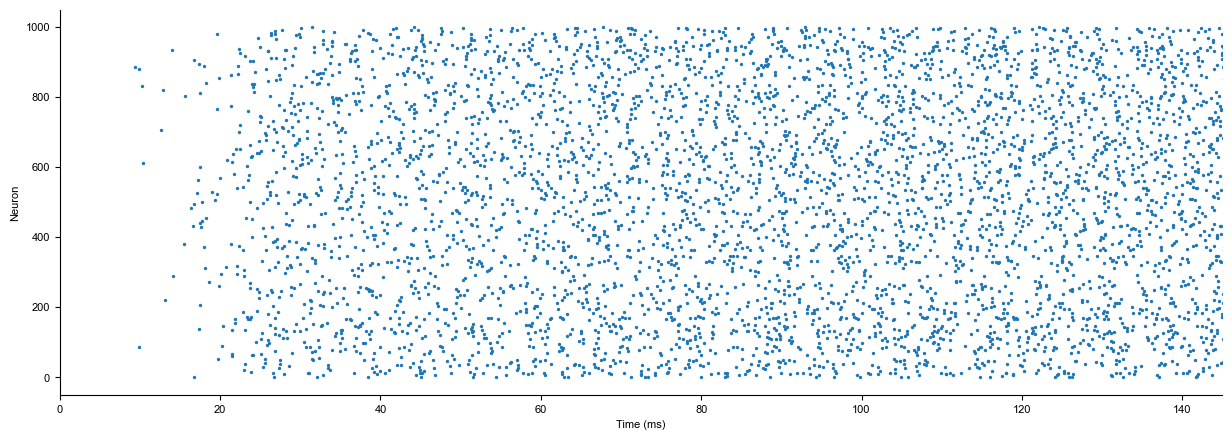

In [7]:
pnm.want_all_spikes() #will record spikes from all the neurons
    
set_global_synaptic_conductance(1.8e-4, G, pnm)
h.v_init = -70
t_init = 150

h.tstop = t_init+70
h.init()
pnm.run()

x = repack_result(pnm, G, t_init=0)

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(x[:,0], x[:,1], 2)
ax.set(xlabel='Time (ms)', ylabel='Neuron', xlim=[0, h.tstop-75])

### Let's begin! Let's run the network for a while to stabilize

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Neuron'), (0.0, 300.0)]

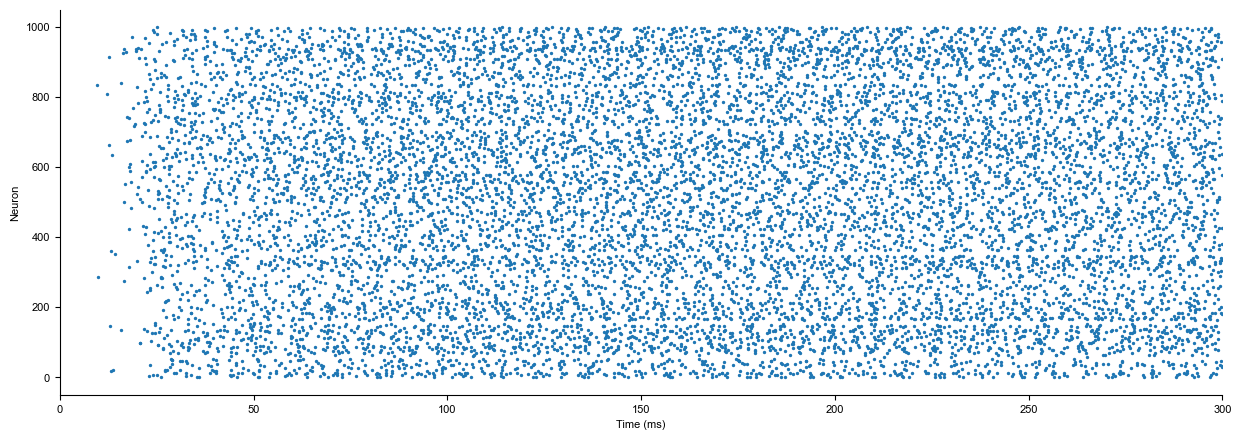

In [8]:
pnm.want_all_spikes()

gexc = 1.8e-4
t_init = 300

set_global_synaptic_conductance(gexc, G, pnm)

h.tstop = t_init
h.init()
pnm.run()

x = repack_result(pnm, G, t_init=0)

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(x[:,0], x[:,1], 2)
ax.set(xlabel='Time (ms)', ylabel='Neuron', xlim=[0, h.tstop])

### Here we define some parameters

In [9]:
# Target function
fref = lambda t: np.sin(2*np.pi*t/500)

# Initial phi
phi = np.zeros(Ncells)
# A matrix that we need for the RLS method
P = np.eye(Ncells)

# Coefficients from two network inputs
G1 = 1
Q1 = 1

# Random feedback to neurons
eta = np.random.uniform(low=-1.0, high=1.0, size=Ncells)

# Batch period length for each iteration
t_batch = 200



In [10]:
# we will store computed rates of individual cells in this matrix
r = np.zeros((Ncells, t_batch))

# The integration parameter, roughly the same as synapses in this model
dt = 1.0
tau = 20.0

# A list to collect all the data
x_before_after = []

#Batch count
cbatch = 0

### Let's run a few batches...

In [18]:
# pnm.want_all_spikes()
for i_batch in trange(cbatch, cbatch+10, 1):

    # When the batch starts
    t_batch_start = t_init + (i_batch)*t_batch

    # For every netcons ...
    for nc in pnm.netcons:
        # for connecting i -> k
        k, i, _ = nc
        
        # synaptic weight is determined by the original + feedback from phi
        g = gexc*(G[i][k]['weight']*G1 + eta[i]*phi[k]*Q1)
        pnm.netcons[nc].weight[0] = g

    
    # Run the simulation briefly
    pnm.continuerun(t_batch_start + t_batch)


    # Collect the spike data
    x = repack_result(pnm, G, t_init=t_batch_start)

    # Transform the spikes into a matrix (Ncells, t_batch)
    s_all = np.zeros((Ncells, t_batch), dtype='float')
    x = x[x[:,0]<=t_batch,:]
    s_all[x[:,1].astype(int), x[:,0].astype(int)] = 1
    s = s_all[:,:]

    # Turn it into a rate
    for i in range(s.shape[1]):
        if i==0:
            r_prev = r[:,-1]
        else:
            r_prev = r[:, i-1]
        r[:,i] = (r_prev + s[:,i]*dt)/(1+dt/tau)

    # Collect the data before optimization
    tt = np.arange(t_batch) + t_batch_start
    x_before_after.append([tt, r.mean(axis=0), fref(tt), np.matmul(phi, r)])

    # RLS: See Nicola and Clopath for the details
    for t in range(t_batch):
        Pr = np.matmul(P, r[:,t])
        PrrP = np.matmul(Pr[:,np.newaxis], Pr[np.newaxis,:])
        rPr = np.matmul(r[:,t], Pr)
        P = P - PrrP/(1 + rPr)

        Pr = np.matmul(P, r[:,t])

        err = np.matmul(phi, r[:,t]) - fref(t+t_batch_start)
        phi = phi - err*Pr

    # Store the final result
    x_before_after[-1].append(np.matmul(phi, r))
    
cbatch = i_batch+1
print(f'Next batch starts at batch = {cbatch}')

  0%|          | 0/10 [00:00<?, ?it/s]

Next batch starts at batch = 40


### Let's check the results!

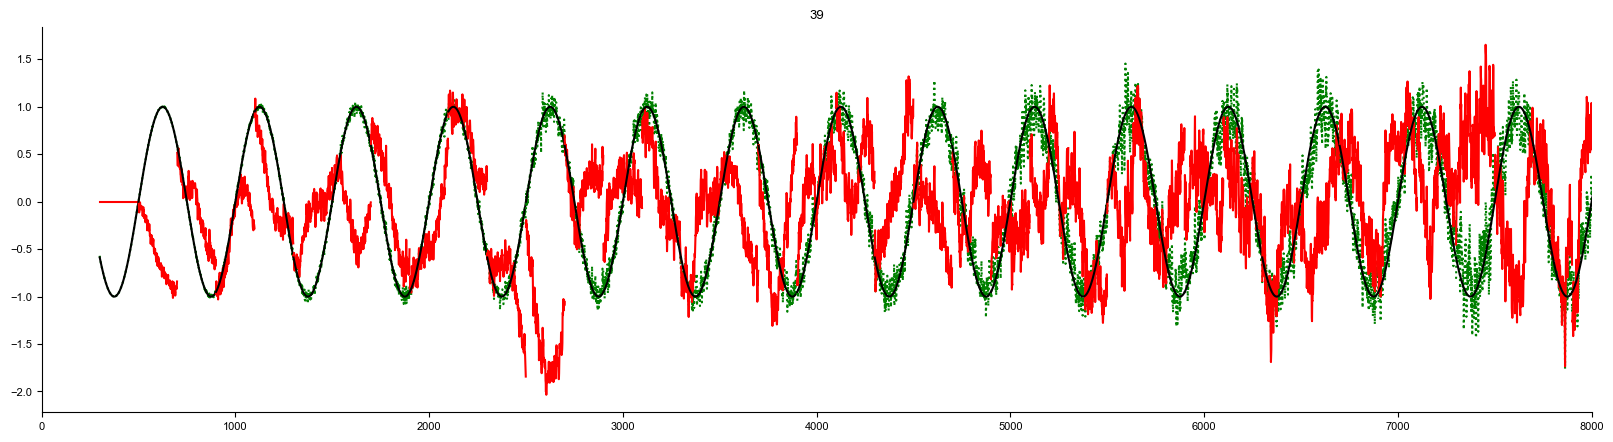

In [20]:
_, ax = plt.subplots(figsize=(20,5))

for t, _, xt, xhb, xha in x_before_after:
    # ax.plot(t, 10*(rmean-rmean.mean()), 'c')
    ax.plot(t, xha,':g')
    ax.plot(t, xhb,'r')
    ax.plot(t, xt,'-k')
    ax.set_title(i_batch)
    # ax.set_ylim([-1-0.5,1.5])
    ax.set_xlim([0*(cbatch*t_batch-4000), cbatch*t_batch])